# 2. Images & Convolutional Neural Networks

Train neural networks to solve image classification tasks. In this chapter, you will learn how to handle image data in PyTorch and get to grips with convolutional neural networks (CNNs). You will practice training and evaluating an image classifier while learning about how to improve the model performance with data augmentation.

## Prepare environment

In [1]:
# Importing libraries
import expectexception
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim

from environment import prepare_environment
from pprint import pprint

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchmetrics import Precision, Recall

In [2]:
# Global variables
SEED = 42

DATASET_CLOUD_TRAIN = "data-sources/clouds/clouds_train/"
DATASET_CLOUD_TEST = "data-sources/clouds/clouds_test/"

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
print(torch.__version__)
print('Cuda is available?', torch.cuda.is_available())

2.4.1+cu124
Cuda is available? True


In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)

## 2.1 Handling images with PyTorch

### Reviewing the Cloud Image Dataset

In [5]:
print('TRAIN DATASET:')
total = 0
for directory in os.listdir(DATASET_CLOUD_TRAIN):
    num_files = sum([len(f) for _, _, f in os.walk(DATASET_CLOUD_TRAIN + directory)])
    print(f'- {directory}: {num_files}')
    total += num_files
print('Total images:', total)

TRAIN DATASET:
- cirriform clouds: 66
- clear sky: 60
- cumulonimbus clouds: 14
- cumulus clouds: 91
- high cumuliform clouds: 133
- stratiform clouds: 49
- stratocumulus clouds: 61
Total images: 474


In [6]:
print('TEST DATASET:')
total = 0
for directory in os.listdir(DATASET_CLOUD_TEST):
    num_files = sum([len(f) for _, _, f in os.walk(DATASET_CLOUD_TEST + directory)])
    print(f'- {directory}: {num_files}')
    total += num_files
print('Total images:', total)

TEST DATASET:
- cirriform clouds: 77
- clear sky: 64
- cumulonimbus clouds: 11
- cumulus clouds: 120
- high cumuliform clouds: 103
- stratiform clouds: 40
- stratocumulus clouds: 71
Total images: 486


### Loading images to PyTorch

In [7]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((128, 128)),
                                      ])

dataset_train = ImageFolder(DATASET_CLOUD_TRAIN,
                            transform=train_transforms,)
print("Number of images in train dataset:", len(dataset_train))
dataset_train

Number of images in train dataset: 474


Dataset ImageFolder
    Number of datapoints: 474
    Root location: data-sources/clouds/clouds_train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
           )

In [8]:
# Reviewing labels in datasets
print("Labels included in dataset")
pprint(dataset_train.class_to_idx)

Labels included in dataset
{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}


### Displaying images

In [9]:
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1,)

image, label = next(iter(dataloader_train))
print("Data point:", image.shape)

image = image.squeeze()
image = image.permute(1, 2, 0)
print("Image reshaped", image.shape)

Data point: torch.Size([1, 3, 128, 128])
Image reshaped torch.Size([128, 128, 3])


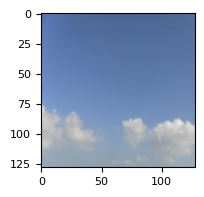

In [10]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

### Data augmentation

Number of images in train dataset: 474
Data point: torch.Size([1, 3, 128, 128])
Image reshaped torch.Size([128, 128, 3])


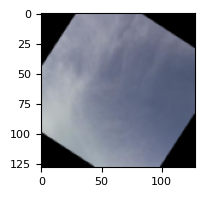

In [11]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.ToTensor(),
                                       transforms.Resize((128, 128)),
])

dataset_train = ImageFolder(DATASET_CLOUD_TRAIN, transform=train_transforms)
print("Number of images in train dataset:", len(dataset_train))

dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1,)

image, label = next(iter(dataloader_train))
print("Data point:", image.shape)

image = image.squeeze()
image = image.permute(1, 2, 0)
print("Image reshaped", image.shape)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

### Ex.1 - Image dataset
Let's start with building a Torch Dataset of images. You'll use it to explore the data and, later, to feed it into a model.

The training data for the cloud classification task is stored in the following directory structure:

```
clouds_train
    - cirriform clouds
        - 539cd1c356e9c14749988a12fdf6c515.jpg
        - ...
    - clear sky
    - cumulonimbus clouds
    - cumulus clouds
    - high cumuliform clouds
    - stratiform clouds
    - stratocumulus clouds
```

There are seven folders inside `clouds_train`, each representing one cloud type (or a clear sky). Inside each of these folders sit corresponding image files.

The following imports have already been done for you:

```
from torchvision.datasets import ImageFolder
from torchvision import transforms
```

**Instructions**

1. Compose two transformations, the first, to parse the image to a tensor, and one to resize the image to `128` by `128`, assigning them to train_transforms.
2. Use `ImageFolder` to define `dataset_train`, passing it the directory path to the data (`"clouds_train"`) and the transforms defined earlier.

In [12]:
# Compose transformations
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Resize((128, 128))])

# Create Dataset using ImageFolder
dataset_train = ImageFolder(DATASET_CLOUD_TRAIN, transform=train_transforms)
print("Number of images in train dataset:", len(dataset_train))

Number of images in train dataset: 474


### Ex.2 - Data augmentation in PyTorch

Let's include data augmentation in your Dataset and inspect some images visually to make sure the desired transformations are applied.

First, you'll add the augmenting transformations to `train_transforms`. Let's use a random horizontal flip and a rotation by a random angle between `0` and `45` degrees. The code that follows to create the Dataset and the DataLoader is exactly the same as before. Finally, you'll reshape the image and display it to see if the new augmenting transformations are visible.

All the imports you need have been called for you:
```
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
```

Time to augment some cloud photos!

**Instructions**

1. Add two more transformations to `train_transforms` to perform a random horizontal flip and then a rotation by a random angle between 0 and 45 degrees.
2. Reshape the `image` tensor from the DataLoader to make it suitable for display.
3. Display the image.

Number of images in train dataset: 474
Data point: torch.Size([1, 3, 128, 128])
Image reshaped torch.Size([128, 128, 3])


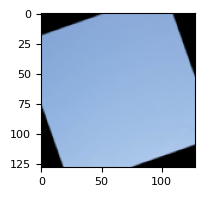

In [13]:
# Prepare image transformations
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(degrees=(0, 45)),
                                       transforms.ToTensor(),
                                       transforms.Resize((128, 128)),
                                      ])

# Define the dataloader
dataset_train = ImageFolder(DATASET_CLOUD_TRAIN,
                            transform=train_transforms,)
print("Number of images in train dataset:", len(dataset_train))
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1)

# Review the result
image, label = next(iter(dataloader_train))
print("Data point:", image.shape)
image = image.squeeze()
image = image.permute(1, 2, 0)
print("Image reshaped", image.shape)
fig = plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

## 2.2 Convolutional Neural Networks

### Model ImageClassifierModel64X64

In [14]:
class ImageClassifierModel64X64(nn.Module):
    """CNN Model implementation in the weather cloud classifier."""
    def __init__(self, num_classes:int) -> None:
        super().__init__()
        torch.manual_seed(SEED)
        
        self.feature_extractor = nn.Sequential(           # Imagine input images 3 X 64 X 64 (channel, width, height)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # Input channel=3, output channel=32 → 32 x 64 x 64
            nn.ELU(),                                     # No Changes → 32 x 64 x 64
            nn.MaxPool2d(kernel_size=2),                  # Divide image size by 2 → 32 x 32 x 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Input channel=32, output channel=64 → 64 x 32 x 32
            nn.ELU(),                                     # No Changes → 64 x 32 x 32
            nn.MaxPool2d(kernel_size=2),                  # Divide image size by 2 → 64 x 16 x 16
            nn.Flatten(),                                 # Flatten image → 64 x 16 x 16
        )
        self.classifier = nn.Linear(64*16*16, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
temp = ImageClassifierModel64X64(num_classes=7)
temp

ImageClassifierModel64X64(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=16384, out_features=7, bias=True)
)

### Ex.3 - Building convolutional networks
You are on a team building a weather forecasting system. As part of the system, cameras will be installed at various locations to take pictures of the sky. Your task is to build a model to classify different cloud types in these pictures, which will help spot approaching weather fronts.

You decide to build a convolutional image classifier. The model will consist of two parts:

- A feature extractor that learns a vector of features from the input image,
- A classifier that predicts the image's class based on the learned features.

Both `torch` and `torch.nn` as `nn` have already been imported for you, so let's get to it!

**Instructions**

1. Define the `feature_extractor` part of the model by adding another convolutional layer with `64` output feature maps, the ELU activation, and a max pooling layer with a window of size two; at the end, flatten the output.

-----------------------
```
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
```

## 2.3 Training image classifiers

### Augmentations for cloud classification

In [15]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

dataset_train = ImageFolder(DATASET_CLOUD_TRAIN, transform=train_transforms,)
print("Number of images in train dataset:", len(dataset_train))
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=10,)

# Reviewing labels in datasets
print("Labels included in dataset")
pprint(dataset_train.class_to_idx)

Number of images in train dataset: 474
Labels included in dataset
{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}


### Model ImageClassifierModel128*128

In [16]:
class ImageClassifierModel128X128(nn.Module):
    """CNN model for image cloud classifier problems.
    """
    def __init__(self, num_classes:int, seed:int=SEED) -> None:
        super().__init__()
        torch.manual_seed(SEED)
        
        self.feature_extractor = nn.Sequential(           # Input images 3 X 128 X 128 (channel, width, height)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # Input channel=3, output channel=32 → 32 x 128 x 128
            nn.ELU(),                                     # No Changes → 32 x 128 x 128
            nn.MaxPool2d(kernel_size=2),                  # Divide image size by 2 → 32 x 64 x 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Input channel=32, output channel=64 → 64 x 64 x 64
            nn.ELU(),                                     # No Changes → 64 x 64 x 64
            nn.MaxPool2d(kernel_size=2),                  # Divide image size by 2 → 64 x 32 x 32
            nn.Flatten(),                                 # Flatten image → 64 x 32 x 32
        )
        self.classifier = nn.Linear(64*32*32, num_classes)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

### Build the model

In [17]:
# Build the model
model128X128 = ImageClassifierModel128X128(num_classes=7)
print(model128X128)

# Set the criterion and teh optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model128X128.parameters(), lr=0.001)

ImageClassifierModel128X128(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=65536, out_features=7, bias=True)
)


In [18]:
# Train the model
losses = []

epochs = 10
model128X128.train()
for epoch in range(epochs):
    for X, y in dataloader_train:                   # Get feature and target from the data loader
        optimizer.zero_grad()                       # zero the parameter gradients
        y_out = model128X128(X)                     # Run a forward pass
        loss = criterion(y_out, y)                  # Compute loss
        loss.backward()                             # Backward pass
        optimizer.step()                            # Optimization

    losses.append(loss.item())                      # Record the loss per epoch
    
    print(f'Epoch [{epoch+1}], Loss: {loss.item():.6f}')

Epoch [1], Loss: 1.887146
Epoch [2], Loss: 1.566640
Epoch [3], Loss: 1.093598
Epoch [4], Loss: 1.180845
Epoch [5], Loss: 1.480847
Epoch [6], Loss: 1.369050
Epoch [7], Loss: 2.060340
Epoch [8], Loss: 1.228644
Epoch [9], Loss: 0.985049
Epoch [10], Loss: 0.966866


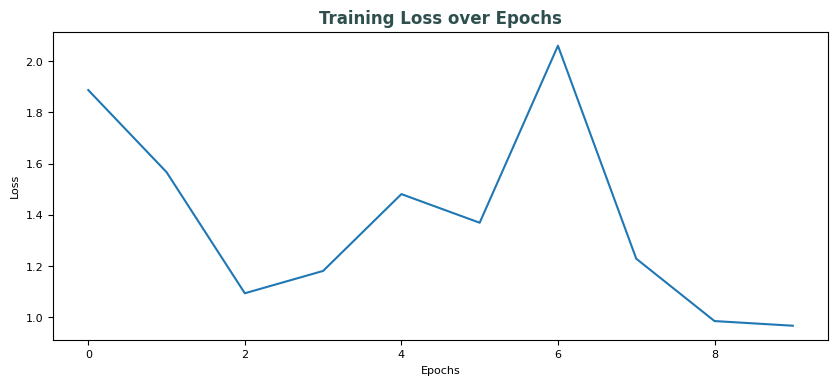

In [19]:
# Visualizing the loss and accuracy in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Ex.4 - Dataset with augmentations
You have already built the image dataset from cloud pictures and the convolutional model to classify different cloud types. Before you train it, let's adapt the dataset by adding the augmentations that could improve the model's cloud classification performance.

The code to set up the Dataset and DataLoader is already prepared for you and should look familiar. Your task is to define the composition of transforms that will be applied to the input images as they are loaded.

Note that before you were resizing images to 128 by 128 to display them nicely, but now you will use smaller ones to speed up training. As you will see later, 64 by 64 will be large enough for the model to learn.

`from torchvision import transforms` has been already executed for you, so let's get to it!

**Instructions**

1. Define `train_transforms` by composing together five transformations: a random horizontal flip, random rotation (by angle from 0 to 45 degrees), random automatic contrast adjustment, parsing to tensor, and resizing to 64 by 64 pixels.

In [20]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64))
])

dataset_train = ImageFolder(DATASET_CLOUD_TRAIN, transform=train_transforms)
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=16)
print("Number of images in train dataset:", len(dataset_train))

image, label = next(iter(dataloader_train))
print("Features Shape", image.shape)
print("Label Shape", label.shape)

Number of images in train dataset: 474
Features Shape torch.Size([16, 3, 64, 64])
Label Shape torch.Size([16])


### Ex.5 - Image classifier training loop
It's time to train the image classifier! You will use the model you defined earlier and train it to distinguish between seven cloud types.

To define the loss and optimizer, you will need to use functions from `torch.nn` and `torch.optim`, imported for you as `nn` and `optim`, respectively. You don't need to change anything in the training loop itself: it's exactly like the ones you wrote before, with some additional logic to print the loss during training.

**Instructions**

1. Define the model using your model class with `num_classes` set to `7`.
2. Define the loss function as cross-entropy loss and assign it to `criterion`.
3. Define the optimizer as Adam, passing it the model's parameters and the learning rate of `0.001`, and assign it to `optimizer`.
4. Start the training for-loop by iterating over training `images` and `labels`.

In [21]:
# Define the model
model64X64 = ImageClassifierModel64X64(num_classes=7)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model64X64.parameters(), lr=0.001)

# Loop training
epochs = 100
losses = []
for epoch in range(epochs):
    running_loss = 0.0

    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model64X64(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    losses.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")

Epoch 10, Loss: 1.071770
Epoch 20, Loss: 0.847502
Epoch 30, Loss: 0.702454
Epoch 40, Loss: 0.606812
Epoch 50, Loss: 0.605388
Epoch 60, Loss: 0.473880
Epoch 70, Loss: 0.420049
Epoch 80, Loss: 0.424012
Epoch 90, Loss: 0.359085
Epoch 100, Loss: 0.368359


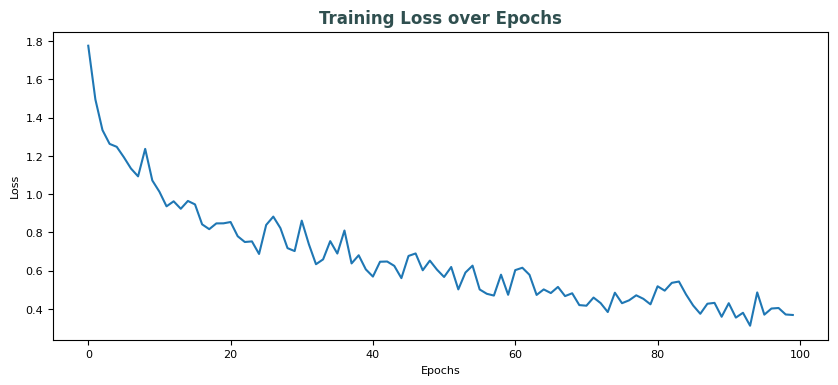

In [22]:
# Visualizing the loss and accuracy in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 2.4 Evaluating image classifiers

### Data augmentation at test time

In [23]:
test_transforms = transforms.Compose([
    #
    # NO DATA AUGMENTATION AT TEST TIME
    #
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])
dataset_test = ImageFolder(DATASET_CLOUD_TEST, transform=test_transforms)
print("Number of images in test dataset:", len(dataset_test))

# Reviewing labels in datasets
print("Labels included in dataset")
pprint(dataset_test.class_to_idx)

Number of images in test dataset: 486
Labels included in dataset
{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}


### Averaging multi-class metrics

In [24]:
recall_per_class = Recall(task="multiclass", num_classes=7, average=None)
recall_micro = Recall(task="multiclass", num_classes=7, average="micro")
recall_macro = Recall(task="multiclass", num_classes=7, average="macro")
recall_weighted = Recall(task="multiclass", num_classes=7, average="weighted")

recall_per_class, recall_micro, recall_macro, recall_weighted

(MulticlassRecall(),
 MulticlassRecall(),
 MulticlassRecall(),
 MulticlassRecall())

### Evaluation loop

In [25]:
# Define the dataloader
dataloader_test = DataLoader(dataset_test, shuffle=True, batch_size=16)

# Set the evaluation metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

# Evaluation loop
model64X64.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model64X64(images)
        _, preds = torch.max(outputs, dim=1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)
precision = metric_precision.compute()
recall = metric_recall.compute()

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.7106484770774841
Recall: 0.7297075986862183


#### Understanding `torch.max`

In [26]:
temp = torch.randn(4, 4)
print(temp)
print(torch.max(temp, 1))

tensor([[ 1.1724830866, -0.2860434949, -1.2137631178,  0.9021172523],
        [ 0.7136903405,  0.3001082242,  0.4241665900, -0.6594630480],
        [ 2.7089838982,  1.1059490442,  0.9476607442,  0.6920924783],
        [-0.6813704967,  2.1704947948, -0.1762695014, -0.2779524624]])
torch.return_types.max(
values=tensor([1.1724830866, 0.7136903405, 2.7089838982, 2.1704947948]),
indices=tensor([0, 0, 0, 1]))


### Analyzing performance per class

In [27]:
# Evaluation loop
metric_precision = Precision(task="multiclass", num_classes=7, average=None)
metric_recall = Recall(task="multiclass", num_classes=7, average=None)

model64X64.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model64X64(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)
precision = metric_precision.compute()
recall = metric_recall.compute()

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: tensor([0.7428571582, 0.9552238584, 0.5000000000, 0.8404255509, 0.5496688485,
        0.7954545617, 0.5909090638])
Recall: tensor([0.6753246784, 1.0000000000, 0.7272727489, 0.6583333611, 0.8058252335,
        0.8750000000, 0.3661971688])


In [28]:
precision_per_class = {k: precision[v].item()
                       for k, v
                       in dataset_test.class_to_idx.items()
                      }
recall_per_class = {k: recall[v].item()
                    for k, v
                    in dataset_test.class_to_idx.items()
                   }
print('Precision:')
pprint(precision_per_class)
print('\nRecall:')
pprint(recall_per_class)

Precision:
{'cirriform clouds': 0.7428571581840515,
 'clear sky': 0.9552238583564758,
 'cumulonimbus clouds': 0.5,
 'cumulus clouds': 0.8404255509376526,
 'high cumuliform clouds': 0.5496688485145569,
 'stratiform clouds': 0.7954545617103577,
 'stratocumulus clouds': 0.5909090638160706}

Recall:
{'cirriform clouds': 0.6753246784210205,
 'clear sky': 1.0,
 'cumulonimbus clouds': 0.7272727489471436,
 'cumulus clouds': 0.6583333611488342,
 'high cumuliform clouds': 0.8058252334594727,
 'stratiform clouds': 0.875,
 'stratocumulus clouds': 0.3661971688270569}


### Ex.6 - Multi-class model evaluation
Let's evaluate our cloud classifier with precision and recall to see how well it can classify the seven cloud types. In this multi-class classification task it is important how you average the scores over classes. Recall that there four approaches:

- Not averaging, and analyzing the results per class;
- Micro-averaging, ignoring the classes and computing the metrics globally;
- Macro-averaging, computing metrics per class and averaging them;
- Weighted-averaging, just like macro but with the average weighted by class size.
- Both Precision and Recall are already imported from torchmetrics. It's time to see how well our model is doing!

**Instructions**

1. Define precision and recall metric"s calculated globally on all examples.
2. Change your code to compute separate recall and precision metrics for each class and average them with a simple average.

In [29]:
# Define precision and recall metric"s calculated globally on all examples.
metric_precision = Precision(task="multiclass", num_classes=7, average='micro')
metric_recall = Recall(task="multiclass", num_classes=7, average='micro')

model64X64.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model64X64(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.7139917612075806
Recall: 0.7139917612075806


In [30]:
# Define precision and recall metric"s for each class and average them with a simple average.
metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

model64X64.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model64X64(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.7106484770774841
Recall: 0.7297075986862183


### Ex.7 - Analyzing metrics per class
While aggregated metrics are useful indicators of the model's performance, it is often informative to look at the metrics per class. This could reveal classes for which the model underperforms.

In this exercise, you will run the evaluation loop again to get our cloud classifier's precision, but this time per-class. Then, you will map these score to the class names to interpret them. As usual, Precision has already been imported for you. Good luck!

**Instructions**

1. Define a precision metric appropriate for per-class results.
2. Calculate the precision per class by finishing the dict comprehension, iterating over the `.items()` of the `.class_to_idx` attribute of `dataset_test`.

In [31]:
# Define precision metric
metric_precision = Precision(task="multiclass", num_classes=7, average=None)

model64X64.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model64X64(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {k: precision[v].item() for k, v in dataset_test.class_to_idx.items()}
print('Precision:')
pprint(precision_per_class)

Precision:
{'cirriform clouds': 0.7428571581840515,
 'clear sky': 0.9552238583564758,
 'cumulonimbus clouds': 0.5,
 'cumulus clouds': 0.8404255509376526,
 'high cumuliform clouds': 0.5496688485145569,
 'stratiform clouds': 0.7954545617103577,
 'stratocumulus clouds': 0.5909090638160706}


In [32]:
print(dataset_test.class_to_idx)
precision[0].item()

{'cirriform clouds': 0, 'clear sky': 1, 'cumulonimbus clouds': 2, 'cumulus clouds': 3, 'high cumuliform clouds': 4, 'stratiform clouds': 5, 'stratocumulus clouds': 6}


0.7428571581840515

-------------------------------